In [1]:
# Python 3 compatability
from __future__ import division, print_function
from builtins import range

# system functions that are always useful to have
import time, sys, os

# basic numeric setup
import numpy as np
import math
from numpy import linalg
from scipy.interpolate import interp1d, RegularGridInterpolator
from astropy.cosmology import Planck13 as cosmo
import sys, time

# inline plotting
%matplotlib inline


# plotting
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sea
# seed the random number generator
np.random.seed(7)

from spec_exam import Gen_spec
from sim_engine import forward_model_grism, Salmon, F_lam_per_M
import fsps
from spec_id import *
from spec_tools import Oldest_galaxy, Photometry
from spec_stats import Highest_density_region

import dynesty
from dynesty import plotting as dyplot
from glob import glob

from dynesty.dynamicsampler import stopping_function, weight_function
from dynesty.utils import quantile as _quantile
from scipy.ndimage import gaussian_filter as norm_kde

from prospect.models.transforms import logsfr_ratios_to_masses
from multiprocessing import Pool
from scipy import stats
from scipy.special import erf, erfinv

import george
from george import kernels

In [7]:
sp = fsps.StellarPopulation(imf_type = 0, tpagb_norm_type=0, zcontinuous = 1, logzsol = 0, sfh = 3, dust_type = 1)
# sp = fsps.StellarPopulation(imf_type = 2, tpagb_norm_type=0, zcontinuous = 1, logzsol = 0, sfh = 1, tau=0.1, dust_type = 1)

Gs = Gen_spec('GSD', 39170, 1.023,
               g102_lims=[8300, 11288], g141_lims=[11288, 16500],mdl_err = False,
            phot_errterm = 0.02, irac_err = 0.04, decontam = True) 

cleaned


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


In [8]:
###############
###set prior###
###############
specz = 1.023
agelim = Oldest_galaxy(specz)

def prior(u):
    m = Gaussian_prior(u[0], [0.002,0.03], 0.019, 0.08)/ 0.019
    a = (agelim - 1)* u[1] + 1
    
    tsamp = np.array([u[2],u[3],u[4],u[5],u[6],u[7],u[8],u[9], u[10], u[11]])

    taus = stats.t.ppf( q = tsamp, loc = 0, scale = 0.3, df =2.)

    m1, m2, m3, m4, m5, m6, m7, m8, m9, m10 = logsfr_ratios_to_masses(logmass = 0, logsfr_ratios = taus, agebins = get_agebins(a)) * 1E9
    
    z = stats.norm.ppf(u[12],loc = specz, scale = 0.005)
    
    d = u[13]
    
    bp1 = Gaussian_prior(u[14], [-0.5,0.5], 0, 0.25)
    
    rp1 = Gaussian_prior(u[15], [-0.5,0.5], 0, 0.25)
        
    ba = log_10_prior(u[16], [0.1,10])
    bb = log_10_prior(u[17], [0.0001,1])
    bl = log_10_prior(u[18], [0.01,1])
    
    ra = log_10_prior(u[19], [0.1,10])
    rb = log_10_prior(u[20], [0.0001,1])
    rl = log_10_prior(u[21], [0.01,1])
            
    lwa = get_lwa([m, a, m1, m2, m3, m4, m5, m6, m7, m8, m9, m10], get_agebins(a),sp)[0]

    return [m, a, m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, z, d, bp1, rp1, ba, bb, bl, ra, rb, rl, lwa]

# sp.params['logzsol'] = 0

def phot_prior(u):
#     m = Gaussian_prior(u[0], [0.002,0.03], 0.019, 0.08)/ 0.019
    a = (agelim - 1)* u[0] + 1
    
    tsamp = np.array([u[1],u[2],u[3],u[4],u[5],u[6],u[7],u[8], u[9], u[10]])

    taus = stats.t.ppf( q = tsamp, loc = 0, scale = 0.3, df =2.)

    m1, m2, m3, m4, m5, m6, m7, m8, m9, m10 = logsfr_ratios_to_masses(logmass = 0, logsfr_ratios = taus, agebins = get_agebins(a)) * 1E9
    
    z = stats.norm.ppf(u[11],loc = specz, scale = 0.005)
    
    d = u[12]
            
    lwa = get_lwa([1, a, m1, m2, m3, m4, m5, m6, m7, m8, m9, m10], get_agebins(a),sp)[0]

#     return [m, a, m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, z, d, lwa]
    return [a, m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, z, d, lwa]

def g102_prior(u):
    m = Gaussian_prior(u[0], [0.002,0.03], 0.019, 0.08)/ 0.019
    a = (agelim - 1)* u[1] + 1
    
    tsamp = np.array([u[2],u[3],u[4],u[5],u[6],u[7],u[8],u[9], u[10], u[11]])

    taus = stats.t.ppf( q = tsamp, loc = 0, scale = 0.3, df =2.)

    m1, m2, m3, m4, m5, m6, m7, m8, m9, m10 = logsfr_ratios_to_masses(logmass = 0, logsfr_ratios = taus, agebins = get_agebins(a)) * 1E9
    
    z = stats.norm.ppf(u[12],loc = specz, scale = 0.005)
    
    d = u[13]
    
    bp1 = Gaussian_prior(u[14], [-0.5,0.5], 0, 0.25)
           
    ba = log_10_prior(u[15], [0.1,10])
    bb = log_10_prior(u[16], [0.0001,1])
    bl = log_10_prior(u[17], [0.01,1])
       
    lwa = get_lwa([m, a, m1, m2, m3, m4, m5, m6, m7, m8, m9, m10], get_agebins(a),sp)[0]

    return [m, a, m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, z, d, bp1, ba, bb, bl, lwa]


def g141_prior(u):
    m = Gaussian_prior(u[0], [0.002,0.03], 0.019, 0.08)/ 0.019
    a = (agelim - 1)* u[1] + 1
    
    tsamp = np.array([u[2],u[3],u[4],u[5],u[6],u[7],u[8],u[9], u[10], u[11]])

    taus = stats.t.ppf( q = tsamp, loc = 0, scale = 0.3, df =2.)

    m1, m2, m3, m4, m5, m6, m7, m8, m9, m10 = logsfr_ratios_to_masses(logmass = 0, logsfr_ratios = taus, agebins = get_agebins(a)) * 1E9
    
    z = stats.norm.ppf(u[12],loc = specz, scale = 0.005)
    
    d = u[13]
       
    rp1 = Gaussian_prior(u[14], [-0.5,0.5], 0, 0.25)
    
    ra = log_10_prior(u[15], [0.1,10])
    rb = log_10_prior(u[16], [0.0001,1])
    rl = log_10_prior(u[17], [0.01,1])
            
    lwa = get_lwa([m, a, m1, m2, m3, m4, m5, m6, m7, m8, m9, m10], get_agebins(a),sp)[0]

    return [m, a, m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, z, d, rp1, ra, rb, rl, lwa]

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


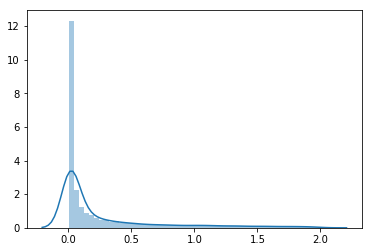

In [6]:
sea.distplot(log_10_prior(np.random.rand(10000),[1E-3,2]))

In [14]:
# sp = fsps.StellarPopulation(imf_type = 0, tpagb_norm_type=0, zcontinuous = 1, logzsol = 0, sfh = 4, tau=0.4)

def all_prior(u):
    m = Gaussian_prior(u[0], [0.002,0.03], 0.019, 0.08)/ 0.019
    a = (agelim - 1)* u[1] + 1
    bsc= Gaussian_prior(u[2], [0.8, 1.2], 1, 0.05)
    rsc= Gaussian_prior(u[3], [0.8, 1.2], 1, 0.05)
    bp1 = Gaussian_prior(u[4], [-0.1,0.1], 0, 0.05)
    rp1 = Gaussian_prior(u[5], [-0.05,0.05], 0, 0.025)
    
    
    tsamp = np.array([u[6],u[7],u[8],u[9],u[10],u[11],u[12], u[13], u[14],u[15]])

    lm = Gaussian_prior(u[16], [9.5, 12.5], 11, 0.75)
    
    taus = stats.t.ppf( q = tsamp, loc = 0, scale = 0.3, df =2.)

    m1, m2, m3, m4, m5, m6, m7, m8, m9, m10 = logsfr_ratios_to_masses(logmass = 0, logsfr_ratios = taus, agebins = get_agebins(a))
    
    z = stats.norm.ppf(u[17],loc = specz, scale = 0.005)
    
    d = log_10_prior(u[18],[1E-3,2])
    
    ba = log_10_prior(u[19], [0.1,10])
    bb = log_10_prior(u[20], [0.0001,1])
    bl = log_10_prior(u[21], [0.01,1])
    
    ra = log_10_prior(u[22], [0.1,10])
    rb = log_10_prior(u[23], [0.0001,1])
    rl = log_10_prior(u[24], [0.01,1])
    
    lwa = get_lwa([m, a, m1, m2, m3, m4, m5, m6, m7, m8, m9, m10], get_agebins(a),sp)[0]
    
    return [m, a, bsc, rsc, bp1, rp1, m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, lm, z, d, ba, bb, bl, ra, rb, rl, lwa]

def phot_prior(u):
    m = Gaussian_prior(u[0], [0.002,0.03], 0.019, 0.08)/ 0.019
    a = (agelim - 1)* u[1] + 1
    
    tsamp = np.array([u[2],u[3],u[4],u[5],u[6],u[7],u[8], u[9], u[10],u[11]])

    lm = Gaussian_prior(u[12], [9.5, 12.5], 11, 0.75)
    
    taus = stats.t.ppf( q = tsamp, loc = 0, scale = 0.3, df =2.)

    m1, m2, m3, m4, m5, m6, m7, m8, m9, m10 = logsfr_ratios_to_masses(logmass = 0, logsfr_ratios = taus, agebins = get_agebins(a))
    
    z = stats.norm.ppf(u[13],loc = specz, scale = 0.005)
    
    d = log_10_prior(u[14],[1E-5,2])
    
    return [m, a, m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, lm, z, d]


def g102_prior(u):
    m = Gaussian_prior(u[0], [0.002,0.03], 0.019, 0.08)/ 0.019
    a = (agelim - 1)* u[1] + 1
    sc= Gaussian_prior(u[2], [0.8, 1.2], 1, 0.05)
    p1 = Gaussian_prior(u[3], [-0.1,0.1], 0, 0.05)
    
    tsamp = np.array([u[4],u[5],u[6],u[7],u[8],u[9],u[10], u[11], u[12], u[13]])

    lm = Gaussian_prior(u[14], [9.5, 12.5], 11, 0.75)
    
    taus = stats.t.ppf( q = tsamp, loc = 0, scale = 0.3, df =2.)

    m1, m2, m3, m4, m5, m6, m7, m8, m9, m10 = logsfr_ratios_to_masses(logmass = 0, logsfr_ratios = taus, agebins = get_agebins(a))
    
    z = stats.norm.ppf(u[15],loc = specz, scale = 0.005)
    
    d = log_10_prior(u[16],[1E-5,2])
    
    return [m, a, sc, p1, m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, lm, z, d]


def g141_prior(u):
    m = Gaussian_prior(u[0], [0.002,0.03], 0.019, 0.08)/ 0.019
    a = (agelim - 1)* u[1] + 1
    sc= Gaussian_prior(u[2], [0.8, 1.2], 1, 0.05)
    p1 = Gaussian_prior(u[3], [-0.1,0.1], 0, 0.05)
    
    tsamp = np.array([u[4],u[5],u[6],u[7],u[8],u[9],u[10], u[11], u[12], u[13]])

    lm = Gaussian_prior(u[14], [9.5, 12.5], 11, 0.75)
    
    taus = stats.t.ppf( q = tsamp, loc = 0, scale = 0.3, df =2.)

    m1, m2, m3, m4, m5, m6, m7, m8, m9, m10 = logsfr_ratios_to_masses(logmass = 0, logsfr_ratios = taus, agebins = get_agebins(a))
    
    z = stats.norm.ppf(u[15],loc = specz, scale = 0.005)
    
    d = log_10_prior(u[16],[1E-5,2])
    
    return [m, a, sc, p1, m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, lm, z, d]

def phot_L(X):
    m, a, m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, lm, z, d = X
    
    sp.params['dust2'] = d
    sp.params['dust1'] = d
    sp.params['logzsol'] = np.log10(m)
    
    time, sfr, tmax = convert_sfh(get_agebins(a), [m1, m2, m3, m4, m5, m6, m7, m8, m9, m10], maxage = a*1E9)

    sp.set_tabular_sfh(time,sfr)    
    
    wave, flux = sp.get_spectrum(tage = a, peraa = True)

    Pmfl = Gs.Sim_phot_mult(wave * (1 + z),F_lam_per_M(flux,wave*(1 + z), z,0,sp.stellar_mass)*10**lm)

    return -np.sum((( Gs.Pflx - Pmfl) / Gs.Perr )**2)/ 2


def g102_L(X):
    m, a, sc, p1, m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, lm, z, d = X
    
    sp.params['dust2'] = d
    sp.params['dust1'] = d
    sp.params['logzsol'] = np.log10(m)
    
    time, sfr, tmax = convert_sfh(get_agebins(a), [m1, m2, m3, m4, m5, m6, m7, m8, m9, m10], maxage = a*1E9)

    sp.set_tabular_sfh(time,sfr) 
    
    wave, flux = sp.get_spectrum(tage = a, peraa = True)
    
    Gmfl = forward_model_all_beams(Gs.Bbeam, Gs.Btrans, Gs.Bwv, wave * (1 + z), 
                                   F_lam_per_M(flux,wave*(1+z), z, 0, sp.stellar_mass)*10**lm)
    
    rGmfl = Gmfl*(p1 * (Gs.Bwv -(Gs.Bwv[-1] + Gs.Bwv[0])/2 ) + 1E3)
    rscale = Scale_model(Gmfl,np.ones_like(Gmfl),rGmfl)
    
    return -np.sum((( Gs.Bfl - rscale * rGmfl * sc) / Gs.Ber )**2 )/2

def g141_L(X):
    m, a, sc, p1, m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, lm, z, d= X
    
    sp.params['dust2'] = d
    sp.params['dust1'] = d
    sp.params['logzsol'] = np.log10(m)
    
    time, sfr, tmax = convert_sfh(get_agebins(a), [m1, m2, m3, m4, m5, m6, m7, m8, m9, m10], maxage = a*1E9)

    sp.set_tabular_sfh(time,sfr) 
    
    wave, flux = sp.get_spectrum(tage = a, peraa = True)
    
    Gmfl = forward_model_all_beams(Gs.Rbeam, Gs.Rtrans, Gs.Rwv, wave * (1 + z), 
                                   F_lam_per_M(flux,wave*(1 + z), z, 0, sp.stellar_mass)*10**lm)
    
    rGmfl = Gmfl*(p1 * (Gs.Rwv -(Gs.Rwv[-1] + Gs.Rwv[0])/2 ) + 1E3)
    rscale = Scale_model(Gmfl,np.ones_like(Gmfl),rGmfl)
    
    return -np.sum((( Gs.Rfl - rscale * rGmfl * sc) / Gs.Rer )**2 )/2

def Full_calibrate_2(Gmfl, p1, sc):
    for i in range(len(wvs)):
        rGmfl= Gmfl[i] * (p1[i] * (wvs[i] -(wvs[i][-1] + wvs[i][0])/2 ) + 1E3)
        scale = Scale_model(Gmfl[i],np.ones_like(Gmfl[i]),rGmfl)
        Gmfl[i] = scale * rGmfl * sc[i]
    return Gmfl

def all_L(X):
    m, a, bsc, rsc, bp1, rp1, m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, lm, z, d, ba, bb, bl, ra, rb, rl, lwa = X
    
    sp.params['dust2'] = d
    sp.params['dust1'] = d
    sp.params['logzsol'] = np.log10(m)
    
    time, sfr, tmax = convert_sfh(get_agebins(a), [m1, m2, m3, m4, m5, m6, m7, m8, m9, m10], maxage = a*1E9)

    sp.set_tabular_sfh(time,sfr) 
    
    wave, flux = sp.get_spectrum(tage = a, peraa = True)

    Gmfl, Pmfl = Full_forward_model(Gs, wave, F_lam_per_M(flux,wave*(1+z),z,0,sp.stellar_mass)*10**lm, z)
       
    Gmfl = Full_calibrate_2(Gmfl, [bp1, rp1], [bsc, rsc])

    return Full_fit_2(Gs, Gmfl, Pmfl, [ba,ra], [bb,rb], [bl, rl])

In [13]:
def Full_forward_model(spec, wave, flux, specz):
    Gmfl = []
    
    for i in range(len(wvs)):
        Gmfl.append(forward_model_all_beams(beams[i], trans[i], wvs[i], wave * (1 + specz), flux))

    Pmfl = spec.Sim_phot_mult(wave * (1 + specz),flux)

    return np.array(Gmfl), Pmfl

def Full_calibrate(Gmfl, p1):
    for i in range(len(wvs)):
        Gmfl[i] = Gmfl[i] * ((p1[i] * wvs[i]) / (wvs[i][-1] - wvs[i][0]) + 5)
    return Gmfl

def Calibrate_grism(spec, Gmfl, p1):
    linecal = []
    for i in range(len(wvs)):
        lines = ((p1[i] * wvs[i]) / (wvs[i][-1] - wvs[i][0]) + 5)
        scale = Scale_model(flxs[i]  / lines, errs[i] / lines, Gmfl[i])    
        linecal.append(scale * lines)
        
    return linecal


def Full_fit(spec, Gmfl, Pmfl):
    Gchi = 0
    
    for i in range(len(wvs)):
        scale = Scale_model(flxs[i], errs[i], Gmfl[i])
        Gchi = Gchi + np.sum(((((flxs[i] / scale) - Gmfl[i]) / (errs[i] / scale))**2))
    
    Pchi = np.sum((((spec.Pflx - Pmfl) / spec.Perr)**2)) * -0.5

    return Gchi, Pchi

def Full_fit_2(spec, Gmfl, Pmfl, a, b, l): 
    Gln = 0
    
    for i in range(len(wvs)):
        scale = Scale_model(flxs[i], errs[i], Gmfl[i])
        noise = noise_model(np.array([wvs[i],flxs[i], errs[i]]).T, Gmfl[i] * scale)
        noise.GP_exp_squared(a[i],b[i],l[i])
        Gln += noise.gp.lnlikelihood(noise.diff)

    Pln = lnlike_phot(spec.Pflx, spec.Perr, Pmfl)
    
    return Gln + Pln

def tab_L(X):
    m, a, m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, z, d, bp1, rp1, ba, bb, bl, ra, rb, rl, lwa = X
    
    sp.params['dust2'] = d
    sp.params['dust1'] = d
    sp.params['logzsol'] = np.log10(m)

    time, sfr, tmax = convert_sfh(get_agebins(a), [m1, m2, m3, m4, m5, m6, m7, m8, m9, m10], maxage = a*1E9)

    sp.set_tabular_sfh(time,sfr)    
    
    wave, flux = sp.get_spectrum(tage = a, peraa = True)

    Gmfl, Pmfl = Full_forward_model(Gs, wave, flux, z)
       
    Gmfl = Full_calibrate(Gmfl, [bp1, rp1])
        
    PC= Full_scale(Gs, Pmfl)

    LOGL = Full_fit_2(Gs, Gmfl, PC*Pmfl, [ba,ra], [bb,rb], [bl, rl])
                 
#     return -0.5 * (Pchi+Gchi)

    return LOGL

def phot_L(X):
#     m, a, m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, z, d, lwa = X
    a, m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, z, d, lwa = X
    
    sp.params['dust2'] = d
    sp.params['dust1'] = d
#     sp.params['logzsol'] = np.log10(m)

    time, sfr, tmax = convert_sfh(get_agebins(a), [m1, m2, m3, m4, m5, m6, m7, m8, m9, m10], maxage = a*1E9)

    sp.set_tabular_sfh(time,sfr)    
    
    wave, flux = sp.get_spectrum(tage = a, peraa = True)

    Pmfl = Gs.Sim_phot_mult(wave * (1 + z),flux)
       
    PC= Full_scale(Gs, Pmfl)

    return lnlike_phot(Gs.Pflx, Gs.Perr, PC*Pmfl)

def g102_L(X):
    m, a, m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, z, d, bp1, ba, bb, bl, lwa = X    
    sp.params['dust2'] = d
    sp.params['dust1'] = d
    sp.params['logzsol'] = np.log10(m)

    time, sfr, tmax = convert_sfh(get_agebins(a), [m1, m2, m3, m4, m5, m6, m7, m8, m9, m10], maxage = a*1E9)

    sp.set_tabular_sfh(time,sfr)    
    
    wave, flux = sp.get_spectrum(tage = a, peraa = True)

    Gmfl = forward_model_all_beams(Gs.Bbeam, Gs.Btrans, Gs.Bwv, wave * (1 + z), flux)
    
    Gmfl = Gmfl * ((bp1 *Gs.Bwv) / (Gs.Bwv[-1] - Gs.Bwv[0]) + 5)

    scale =   Scale_model(Gs.Bfl, Gs.Ber, Gmfl)

    noise = noise_model(np.array([Gs.Bwv,Gs.Bfl, Gs.Ber]).T, Gmfl * scale)
    noise.GP_exp_squared(ba,bb,bl)
    
    return noise.gp.lnlikelihood(noise.diff)

def g141_L(X):
    m, a, m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, z, d, rp1, ra, rb, rl, lwa = X    
    sp.params['dust2'] = d
    sp.params['dust1'] = d
    sp.params['logzsol'] = np.log10(m)

    time, sfr, tmax = convert_sfh(get_agebins(a), [m1, m2, m3, m4, m5, m6, m7, m8, m9, m10], maxage = a*1E9)

    sp.set_tabular_sfh(time,sfr)    
    
    wave, flux = sp.get_spectrum(tage = a, peraa = True)

    Gmfl = forward_model_all_beams(Gs.Rbeam, Gs.Rtrans, Gs.Rwv, wave * (1 + z), flux)
    
    Gmfl = Gmfl * ((rp1 *Gs.Rwv) / (Gs.Rwv[-1] - Gs.Rwv[0]) + 5)

    scale = Scale_model(Gs.Rfl, Gs.Rer, Gmfl)

    noise = noise_model(np.array([Gs.Rwv,Gs.Rfl, Gs.Rer]).T, Gmfl * scale)
    noise.GP_exp_squared(ra,rb,rl)
    
    return noise.gp.lnlikelihood(noise.diff)

In [7]:
dsampler = dynesty.NestedSampler(phot_L, phot_prior, ndim = 15, pool=Pool(processes=8), queue_size=8, sample = 'rwalk')

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/dynesty/sampling.py:200: UserWarning: Random number generation appears to be extremely inefficient. Bounding distributions might be sub-optimal.
  warnings.warn("Random number generation appears to be "
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/dynesty/sampling.py:200: UserWarning: Random number generation appears to be extremely inefficient. Bounding distributions might be sub-optimal.
  warnings.warn("Random number generation appears to be "


In [8]:
dsampler.run_nested(print_progress=True)

dres = dsampler.results

iter: 11535+500 | bound: 622 | nc: 1 | ncall: 268294 | eff(%):  4.486 | loglstar:   -inf < -10.281 <    inf | logz: -32.786 +/-  0.212 | dlogz:  0.001 >  0.509            /Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/dynesty/sampler.py:220: RuntimeWarning: invalid value encountered in sqrt
  ('logzerr', np.sqrt(np.array(self.saved_logzvar))),


In [9]:
bsampler = dynesty.NestedSampler(g102_L, g102_prior, ndim = 18, pool=Pool(processes=8), queue_size=8, sample='rwalk')

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/dynesty/sampling.py:200: UserWarning: Random number generation appears to be extremely inefficient. Bounding distributions might be sub-optimal.
  warnings.warn("Random number generation appears to be "
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/dynesty/sampling.py:200: UserWarning: Random number generation appears to be extremely inefficient. Bounding distributions might be sub-optimal.
  warnings.warn("Random number generation appears to be "
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/dynesty/sampling.py:200: UserWarning: Random number generation appears to be extremely inefficient. Bounding distributions might be sub-optimal.
  warnings.warn("Random number generation appears to be "
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/dynesty/sampling.py:200: UserWarning: Random number generation appears to be extremely inefficient. Boundin

In [10]:
bsampler.run_nested(print_progress=True)

bres = bsampler.results

iter: 7552+500 | bound: 367 | nc: 1 | ncall: 166270 | eff(%):  4.843 | loglstar:   -inf < -57.367 <    inf | logz: -71.779 +/-  0.169 | dlogz:  0.001 >  0.509            /Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/dynesty/sampler.py:220: RuntimeWarning: invalid value encountered in sqrt
  ('logzerr', np.sqrt(np.array(self.saved_logzvar))),


In [11]:
rsampler = dynesty.NestedSampler(g141_L, g141_prior, ndim = 18, pool=Pool(processes=8), queue_size=8, sample = 'rwalk')

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/dynesty/sampling.py:200: UserWarning: Random number generation appears to be extremely inefficient. Bounding distributions might be sub-optimal.
  warnings.warn("Random number generation appears to be "
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/dynesty/sampling.py:200: UserWarning: Random number generation appears to be extremely inefficient. Bounding distributions might be sub-optimal.
  warnings.warn("Random number generation appears to be "
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/dynesty/sampling.py:200: UserWarning: Random number generation appears to be extremely inefficient. Bounding distributions might be sub-optimal.
  warnings.warn("Random number generation appears to be "
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/dynesty/sampling.py:200: UserWarning: Random number generation appears to be extremely inefficient. Boundin

In [12]:
rsampler.run_nested(print_progress=True)

rres = rsampler.results

iter: 8586+500 | bound: 428 | nc: 1 | ncall: 190678 | eff(%):  4.765 | loglstar:   -inf < -56.095 <    inf | logz: -72.630 +/-  0.184 | dlogz:  0.001 >  0.509            /Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/dynesty/sampler.py:220: RuntimeWarning: invalid value encountered in sqrt
  ('logzerr', np.sqrt(np.array(self.saved_logzvar))),


In [11]:
wvs, flxs, errs, beams, trans = Gather_grism_data(Gs)

In [15]:
asampler = dynesty.NestedSampler(all_L, all_prior, ndim = 26, pool=Pool(processes=8), queue_size=8, sample = 'rwalk')

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/dynesty/sampling.py:207: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/dynesty/sampling.py:207: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/dynesty/sampling.py:207: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/dynesty/sampling.py:207: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-fa

Exception while calling loglikelihood function:
  params: [ 4.20847778e-01  5.54360147e+00  9.51672295e-01  9.55651172e-01
  6.05663790e-03 -2.05617211e-02  1.00287272e-07  5.98144456e-07
  3.61696098e-06  1.91320531e-05  4.18433705e-05  2.15751805e-05
  6.74374852e-04  2.65294955e-03  3.01282603e-02  9.66457549e-01
  1.15991299e+01  1.02164041e+00  2.42005911e-01  1.48245345e+00
  2.54162625e-02  4.45483706e-02  1.35293344e+00  1.58353336e-02
  2.13265767e-01  5.01768557e+00]Exception while calling loglikelihood function:

  args: []
  params: [ 4.67100946e-01  5.34652202e+00  9.54764519e-01  9.81652633e-01
  2.45274701e-02 -2.98566167e-02  6.28836843e-09  4.01212751e-07
  1.30325120e-06  3.12720893e-06  6.08236416e-06  7.76683654e-06
  1.87177497e-05  6.64998532e-05  2.30252193e-04  9.99665843e-01
  1.16052209e+01  1.02215725e+00  2.34222647e-01  1.35204942e+00
  2.24015444e-02  1.84151460e-01  1.22970302e+00  4.57145624e-03
  5.51414035e-01  4.92850750e+00]
  kwargs: {}
  exception:

Process ForkPoolWorker-31:


  kwargs: {}
Exception while calling loglikelihood function:
  params: [ 4.33224114e-01  5.62994457e+00  1.01932292e+00  9.63648271e-01
 -3.04800818e-04 -1.61887541e-02  4.48999545e-07  1.76760598e-06
  3.44919104e-06  6.35314517e-05  1.10425823e-04  1.10314977e-04
  1.54845691e-04  1.94796025e-03  8.17563967e-03  9.89431616e-01
  1.16033365e+01  1.02220325e+00  2.16257954e-01  1.25399365e+00
  1.54280779e-02  1.26720615e-01  1.33119628e+00  2.50050515e-03
  6.80477551e-01  5.14371035e+00]  exception:


Traceback (most recent call last):
  File "/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/dynesty/sampling.py", line 196, in sample_rwalk
    u_prop = u + scale * du
KeyboardInterrupt
Traceback (most recent call last):
  File "/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/dynesty/dynesty.py", line 805, in __call__
    return self.func(x, *self.args, **self.kwargs)
  Fi

Exception while calling loglikelihood function:
  params: [ 4.18521209e-01  5.46297018e+00  1.01173577e+00  9.49367691e-01
 -3.71020386e-02 -2.56567648e-02  1.64991786e-37  5.41298912e-37
  1.29645698e-36  3.72515715e-36  6.92831883e-36  9.65890429e-36
  1.90494499e-35  8.15114445e-35  4.18785693e-34  1.00000000e+00
  1.16017262e+01  1.02420991e+00  2.18873894e-01  1.47441884e+00
  8.71267413e-04  2.81419817e-01  1.21946900e+00  1.66570465e-03
  4.20786066e-01  5.03659139e+00]


Traceback (most recent call last):


  args: []



  File "/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/dynesty/dynesty.py", line 805, in __call__
    return self.func(x, *self.args, **self.kwargs)


  kwargs: {}
  args: []
Exception while calling prior_transform function:
Exception while calling loglikelihood function:
  params: [ 5.22961875e-01  5.72369460e+00  1.02090538e+00  9.57517332e-01
 -5.43703358e-02 -2.74788981e-02  1.27767109e-05  1.29575763e-05
  1.23723739e-05  3.01635876e-05  2.45826415e-05  4.65057184e-05
  4.90875723e-05  1.54354442e-04  8.42508193e-04  9.98814691e-01
  1.16198552e+01  1.02079588e+00  2.00527364e-01  1.48064011e+00
  1.55282476e-03  1.12132208e-01  1.58468654e+00  2.61451353e-04
  2.89674225e-01  5.25434421e+00]
  args: []
Exception while calling loglikelihood function:


  File "/Users/vestrada/Github/Cluster_and_field/scripts/sim_engine.py", line 379, in F_lam_per_M
    return (c / lam**2) * F_nu_per_M(l_aa, lam, z, Av, m_star)


  params: [ 6.00672883e-01  5.58826444e+00  1.03930117e+00  9.78453697e-01
 -2.50176206e-02 -2.56496564e-02  7.52157796e-09  2.39348861e-08
  4.04336081e-08  2.43988169e-07  3.71015929e-07  5.97045245e-07
  2.86079102e-06  1.04262077e-05  5.43779757e-05  9.99931051e-01
  1.16110385e+01  1.02135612e+00  1.27518533e-01  1.27173898e+00
  5.87052829e-03  1.37462832e-02  1.26785957e+00  1.72169699e-02
  3.08833940e-01  5.15561650e+00]

KeyboardInterrupt
Process ForkPoolWorker-26:


  exception:

  args: []


  File "<ipython-input-14-38e2d92fccc6>", line 174, in all_L
    wave, flux = sp.get_spectrum(tage = a, peraa = True)
Traceback (most recent call last):


  params: [0.2266738  0.94044872 0.43211605 0.32247031 0.29827027 0.09524667
 0.59323253 0.67391994 0.16714198 0.52983574 0.80618268 0.18708149
 0.20426932 0.02070422 0.02508255 0.74570207 0.80288719 0.30951616
 0.72200784 0.54882494 0.42371235 0.72545551 0.60590781 0.59637409
 0.99825885 0.65169097]  kwargs: {}


  File "/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/fsps-0.3.0-py3.5-macosx-10.6-x86_64.egg/fsps/fsps.py", line 582, in get_spectrum
    self._compute_csp()



  exception:


  File "/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/fsps-0.3.0-py3.5-macosx-10.6-x86_64.egg/fsps/fsps.py", line 546, in _compute_csp
    driver.compute_zdep(NSPEC, NTFULL, self._zcontinuous)
  File "/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Traceback (most recent call last):


  kwargs: {}
  kwargs: {}
  exception:


KeyboardInterrupt
  File "/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/dynesty/dynesty.py", line 805, in __call__
    return self.func(x, *self.args, **self.kwargs)
Process ForkPoolWorker-28:


  args: []


  File "<ipython-input-14-38e2d92fccc6>", line 174, in all_L
    wave, flux = sp.get_spectrum(tage = a, peraa = True)


  kwargs: {}


Traceback (most recent call last):
  File "/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/fsps-0.3.0-py3.5-macosx-10.6-x86_64.egg/fsps/fsps.py", line 582, in get_spectrum
    self._compute_csp()
  File "/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):


  exception:


  File "/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/fsps-0.3.0-py3.5-macosx-10.6-x86_64.egg/fsps/fsps.py", line 546, in _compute_csp
    driver.compute_zdep(NSPEC, NTFULL, self._zcontinuous)
  File "/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/dynesty/dynesty.py", line 805, in __call__
    return self.func(x, *self.args, **self.kwargs)
KeyboardInterrupt
  File "/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "<ipython-input-14-38e2d92fccc6>", line 174, in all_L
    wave, flux = sp.get_spectrum(tage = a, peraa = True)
  File "/Users/vestrada/miniconda3/envs/astrocond

  exception:


Traceback (most recent call last):
  File "/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/dynesty/dynesty.py", line 805, in __call__
    return self.func(x, *self.args, **self.kwargs)
  File "<ipython-input-14-38e2d92fccc6>", line 176, in all_L
    Gmfl, Pmfl = Full_forward_model(Gs, wave, F_lam_per_M(flux,wave*(1+z),z,0,sp.stellar_mass)*10**lm, z)
Traceback (most recent call last):
  File "<ipython-input-13-67872c89f954>", line 5, in Full_forward_model
    Gmfl.append(forward_model_all_beams(beams[i], trans[i], wvs[i], wave * (1 + specz), flux))
  File "/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "<ipython-input-14-38e2d92fccc6>", line 174, in all_L
    wave, flux = sp.get_spectrum(tage = a, peraa = True)
Traceback (most recent call last)

In [16]:
asampler.run_nested(print_progress=True)

ares = asampler.results

iter: 13879 | bound: 175 | nc: 25 | ncall: 327680 | eff(%):  4.236 | loglstar:   -inf < 1632.274 <    inf | logz: 1604.196 +/-  0.230 | dlogz: 11.220 >  0.509                                        

KeyboardInterrupt: 

In [ ]:
26272, 41520, 29257, 42113,38843, 42778,39012, 43007,39364, 44042,40223

(<Figure size 864x5616 with 52 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1aa0ac2b38>,
       dtype=object))

<Figure size 1080x360 with 0 Axes>

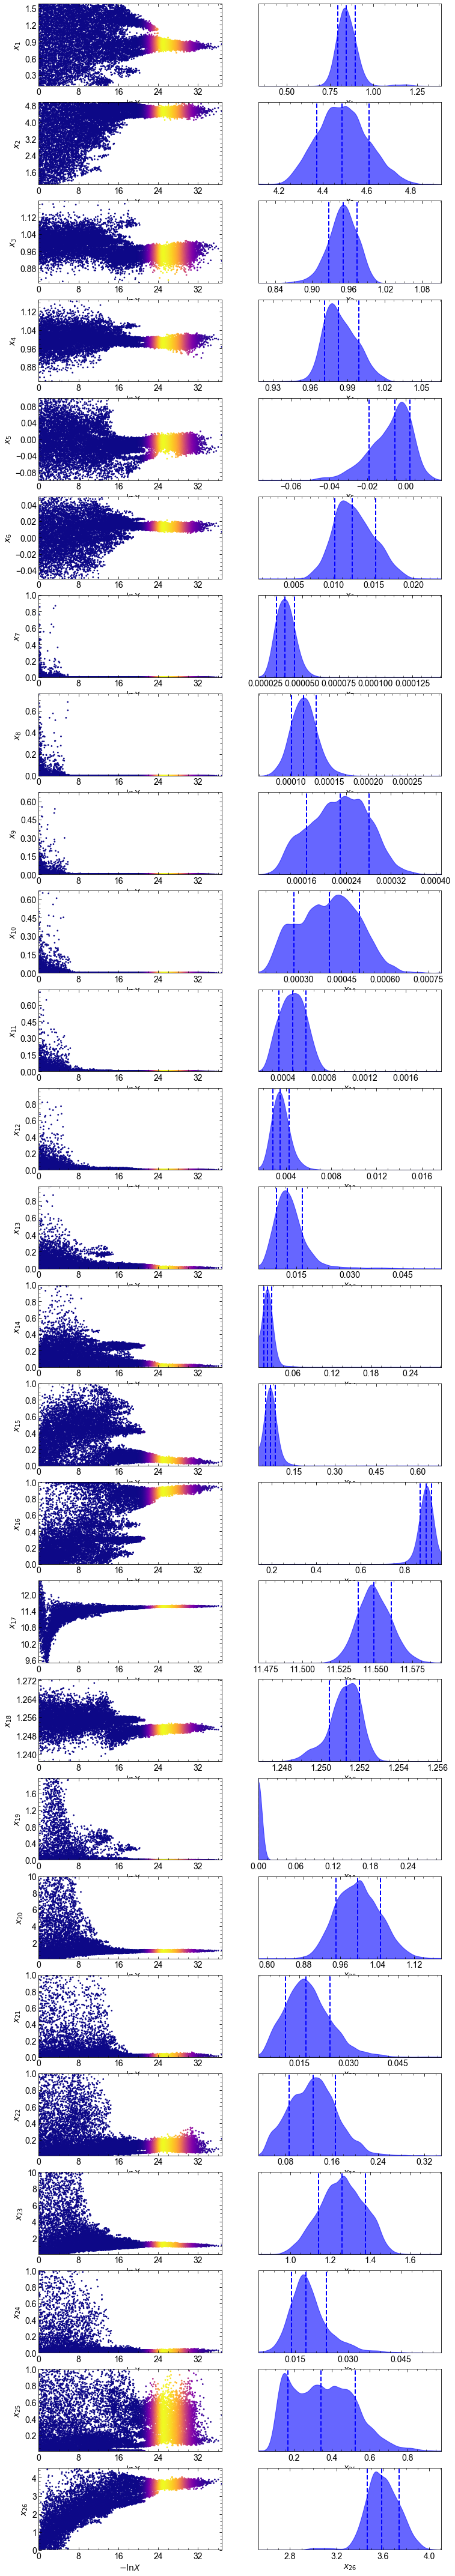

In [59]:
# plt.figure(figsize=[15,5])
# dyplot.traceplot(dres)

# plt.figure(figsize=[15,5])
# dyplot.traceplot(bres)

# plt.figure(figsize=[15,5])
# dyplot.traceplot(rres)

plt.figure(figsize=[15,5])
dyplot.traceplot(ares)

In [32]:
def Calibrate_grism(spec, Gmfl, p1):
    lines = (p1 * (spec[0] -(spec[0][-1] + spec[0][0])/2 ) + 1E3)
    scale = Scale_model(spec[1]  / lines, spec[2] / lines, Gmfl)    
    return scale * lines

In [60]:
m, a, bsc, rsc, bp1, rp1, m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, lm, z, d ,ba,bb,bl,ra,rb,rl, lwa= ares.samples[-1]

sp.params['dust2'] = d
sp.params['dust1'] = d
sp.params['logzsol'] = np.log10(m)

time, sfr, tmax = convert_sfh(get_agebins(a), [m1, m2, m3, m4, m5, m6, m7, m8, m9, m10], maxage = a*1E9)

sp.set_tabular_sfh(time,sfr) 

wave, flux = sp.get_spectrum(tage = a, peraa = True)

Pmfl = Gs.Sim_phot_mult(wave * (1 + z),F_lam_per_M(flux,wave*(1+z),z,0,sp.stellar_mass)*10**lm)   

Bmfl = forward_model_all_beams(Gs.Bbeam, Gs.Btrans, Gs.Bwv, wave * (1 + z), 
                               F_lam_per_M(flux,wave*(1+z),z,0,sp.stellar_mass)*10**lm)
bscale = Calibrate_grism([Gs.Bwv,Gs.Bfl,Gs.Ber], Bmfl, bp1)
# Bchi = -np.sum((( Gs.Bfl - rscale * rGmfl * bsc) / Gs.Ber )**2 )/2

Rmfl = forward_model_all_beams(Gs.Rbeam, Gs.Rtrans, Gs.Rwv, wave * (1 + z), 
                               F_lam_per_M(flux,wave*(1+z),z,0,sp.stellar_mass)*10**lm)
rscale = Calibrate_grism([Gs.Rwv,Gs.Rfl,Gs.Rer], Rmfl, rp1)

# Rchi =  -np.sum((( Gs.Rfl - rscale * rGmfl * rsc) / Gs.Rer )**2 )/2 

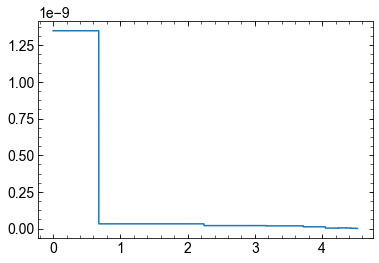

In [61]:
plt.plot(time, sfr)

([<matplotlib.axis.XTick at 0x1a90350eb8>,
 <a list of 5 Text xticklabel objects>)

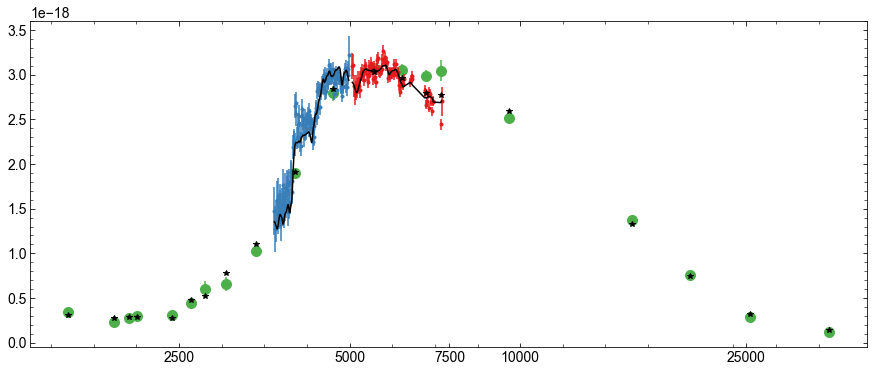

In [62]:
plt.figure(figsize = [15,6])

plt.errorbar(np.log10(Gs.Bwv_rf),Gs.Bfl / (bscale),Gs.Ber / (bscale),
                linestyle='None', marker='o', markersize=3, color='#377eb8',zorder = 2, label = 'CLEAR G102')
plt.errorbar(np.log10(Gs.Rwv_rf),Gs.Rfl / (rscale),Gs.Rer / (rscale),
                linestyle='None', marker='o', markersize=3, color='#e41a1c',zorder = 2, label = '3D-HST G141')
plt.errorbar(np.log10(Gs.Pwv_rf),Gs.Pflx,Gs.Perr,
                                 linestyle='None', marker='o', markersize=10, color='#4daf4a',zorder = 1, label = '3D-HST Photometry')
plt.plot(np.log10(Gs.Bwv_rf), Bmfl, 'k', zorder=5)
plt.plot(np.log10(Gs.Rwv_rf), Rmfl, 'k', zorder=5)
plt.plot(np.log10(Gs.Pwv_rf), Pmfl, 'k*' , zorder=5)

plt.xticks(np.log10([2500,5000,7500,10000,25000]),[2500,5000,7500,10000,25000])

In [50]:
rBmfl = Bmfl*((.1 *Gs.Bwv) )
rscale = Scale_model(Bmfl,np.ones_like(Bmfl),rBmfl)

rBmfl1 = Bmfl*((.1 * (Gs.Bwv - Gs.Bwv[0])))
rscale1 = Scale_model(Bmfl,np.ones_like(Bmfl),rBmfl1)

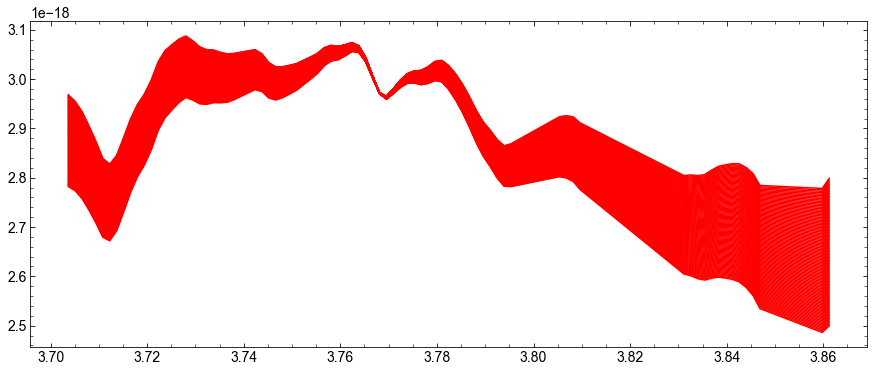

In [104]:
plt.figure(figsize = [15,6])

for i in np.arange(-500,500,10):
    rRmfl = Rmfl*(i * (Gs.Rwv -(Gs.Rwv[-1] + Gs.Rwv[0])/2 ) /(Gs.Rwv[-1] + Gs.Rwv[0]) + 1E3)
    rscale = Scale_model(PC*Rmfl,np.ones_like(Rmfl),rRmfl)
    plt.plot(np.log10(Gs.Rwv_rf), rRmfl * rscale , 'r', zorder=5)
#     plt.plot(np.log10(Gs.Rwv_rf), (i * (Gs.Rwv -(Gs.Rwv[-1] + Gs.Rwv[0])/2 ) /(Gs.Rwv[-1] + Gs.Rwv[0]) + 1E3), 'r', zorder=5)
    
# plt.plot(np.log10(Gs.Rwv_rf), PC*Rmfl, 'k', zorder=5)


<ErrorbarContainer object of 3 artists>

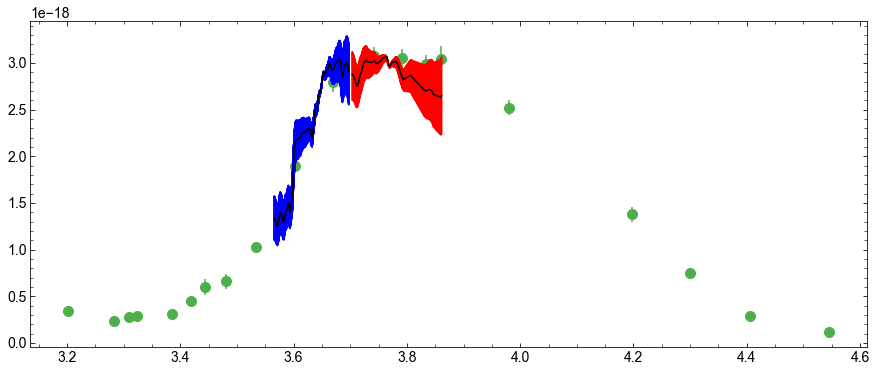

In [110]:
plt.figure(figsize = [15,6])

for i in np.arange(-0.05,0.05,0.001):
    rRmfl = Rmfl*(i * (Gs.Rwv -(Gs.Rwv[-1] + Gs.Rwv[0])/2 ) + 1E3)
    rscale = Scale_model(PC*Rmfl,np.ones_like(Rmfl),rRmfl)
    plt.plot(np.log10(Gs.Rwv_rf), rRmfl * rscale , 'r', zorder=5)
plt.plot(np.log10(Gs.Rwv_rf), PC*Rmfl, 'k', zorder=5)

for i in np.arange(-0.1,0.1,0.001):
    rBmfl = Bmfl*(i * (Gs.Bwv -(Gs.Bwv[-1] + Gs.Bwv[0])/2 ) + 1E3)
    rscale = Scale_model(PC*Bmfl,np.ones_like(Bmfl),rBmfl)

    plt.plot(np.log10(Gs.Bwv_rf), rBmfl * rscale , 'B', zorder=5)
plt.plot(np.log10(Gs.Bwv_rf), PC*Bmfl, 'k', zorder=5)

plt.errorbar(np.log10(Gs.Pwv_rf),Gs.Pflx,Gs.Perr,
                                 linestyle='None', marker='o', markersize=10, color='#4daf4a',zorder = 1, label = '3D-HST Photometry')

In [45]:
np.mean(Gs.Bfl) / 10

2.6487085136879153e-19